# MemAE 2D Memory Input

In [1]:
import os 
import glob as glob

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Download Fmnist from: https://www.kaggle.com/zalando-research/fashionmnist

## Load Data

In [2]:
X_train = pd.read_csv("F_mnist/train.csv")
X_test = pd.read_csv("F_mnist/test.csv")

In [3]:
X_train = X_train.iloc[:,2:].values
X_valid = X_test.iloc[:,1:].values

X_train, X_valid = X_train/255, X_valid/255

In [4]:
X_train = X_train.reshape(X_train.shape[0],28,28)
X_valid = X_valid.reshape(X_valid.shape[0],28,28)

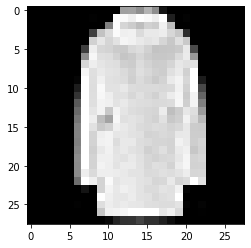

In [5]:
plt.imshow(X_train[6,:,:], cmap="gray")
plt.show()

## Model

In [6]:
class Memory(layers.Layer):
    def __init__(self, mem_dim, fea_dim):
        super(Memory, self).__init__()
        self.mem_dim = mem_dim
        self.fea_dim = fea_dim

        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value=w_init(shape=(self.mem_dim, self.fea_dim), dtype="float32"),
            trainable=True,
        )
        
    def cosine_sim(self, x1, x2):
        num = tf.linalg.matmul(x1, tf.transpose(x2, perm=[1, 0]))
        denom =  tf.linalg.matmul(x1**2, tf.transpose(x2, perm=[1,0])**2)
        w = (num + 1e-12) / (denom + 1e-12)
        return w    
        
    def call(self, z):
        cosim = self.cosine_sim(x1=z, x2=self.w) 
        atteniton = tf.nn.softmax(cosim)
        
        lam = 1 / self.mem_dim # deactivate the 1/N of N memories.

        addr_num = tf.keras.activations.relu(atteniton - lam) * atteniton
        addr_denum = tf.abs(atteniton - lam) + 1e-12
        memory_addr = addr_num / addr_denum
        renorm = tf.clip_by_value(memory_addr, 1e-12, 1-(1e-12))
        z_hat = tf.linalg.matmul(renorm, self.w)
        
        return z_hat, renorm

In [7]:
encoder_inputs = keras.Input(shape=(28, 28))
x = keras.layers.Flatten()(encoder_inputs)
x = layers.Dense(150,activation="selu")(x)
x = layers.Dense(60,activation="selu")(x)
z_hat, att = Memory(100,60)(x)
encoder = keras.Model(encoder_inputs, [z_hat, att], name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 150)               117750    
_________________________________________________________________
dense_1 (Dense)              (None, 60)                9060      
_________________________________________________________________
memory (Memory)              ((None, 60), (None, 100)) 6000      
Total params: 132,810
Trainable params: 132,810
Non-trainable params: 0
_________________________________________________________________


In [8]:
latent_inputs = keras.Input(shape=(60))
x = layers.Dense(60,activation="selu")(latent_inputs)
x = layers.Dense(240,activation="selu")(x)
x = layers.Dense(784,activation="selu")(x)
decoder_outputs = keras.layers.Reshape([28, 28])(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 60)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 60)                3660      
_________________________________________________________________
dense_3 (Dense)              (None, 240)               14640     
_________________________________________________________________
dense_4 (Dense)              (None, 784)               188944    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 207,244
Trainable params: 207,244
Non-trainable params: 0
_________________________________________________________________


In [9]:
class MemAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(MemAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, x):
    
        with tf.GradientTape() as tape:
            z_hat, w_hat = self.encoder(x)
            x_hat = self.decoder(z_hat)

            mse = tf.reduce_sum(tf.square(x - x_hat))
            mem_etrp = tf.reduce_sum((-w_hat) * tf.math.log(w_hat + 1e-12))
            
            loss = tf.reduce_mean(mse + (0.0002 * mem_etrp))
            
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": loss}
    
    def test_step(self, data):
        x, y = data[0],data[1]
        z_hat, w_hat = self.encoder(x)
        x_hat = self.decoder(z_hat)

        mse = tf.reduce_sum(tf.square(x - x_hat))
        mem_etrp = tf.reduce_sum((-w_hat) * tf.math.log(w_hat + 1e-12))
        loss = tf.reduce_mean(mse + (0.0002 * mem_etrp))
        
        return {"loss": loss}
    
    def call(self, inputs):
        z_hat, w_hat = self.encoder(inputs)
        x_hat = self.decoder(z_hat)
        return x_hat, w_hat

In [10]:
model = MemAE(encoder, decoder)
model.compile(optimizer=keras.optimizers.Adam())
model.fit(X_train,validation_data=(X_valid,X_valid), epochs=30, batch_size=32)

Epoch 1/30
1875/1875 [==============================] - 4s 2ms/step - loss: 887.2632 - val_loss: 334.2628
Epoch 2/30
1875/1875 [==============================] - 3s 2ms/step - loss: 652.8082 - val_loss: 322.3066
Epoch 3/30
1875/1875 [==============================] - 3s 2ms/step - loss: 598.4542 - val_loss: 302.4684
Epoch 4/30
1875/1875 [==============================] - 4s 2ms/step - loss: 560.7143 - val_loss: 290.4740
Epoch 5/30
1875/1875 [==============================] - 4s 2ms/step - loss: 538.0453 - val_loss: 283.9334
Epoch 6/30
1875/1875 [==============================] - 5s 2ms/step - loss: 521.9096 - val_loss: 277.7840
Epoch 7/30
1875/1875 [==============================] - 4s 2ms/step - loss: 507.4789 - val_loss: 275.0678
Epoch 8/30
1875/1875 [==============================] - 4s 2ms/step - loss: 491.7701 - val_loss: 263.7147
Epoch 9/30
1875/1875 [==============================] - 4s 2ms/step - loss: 480.3267 - val_loss: 259.8246
Epoch 10/30
1875/1875 [=======================

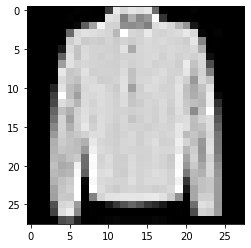

In [33]:
plt.imshow(X_train[8,:,:], cmap="gray")
plt.show()

In [34]:
i = X_train[8,:,:].reshape(1,28,28)
print(i.shape)
xh, _ = model(i)

(1, 28, 28)


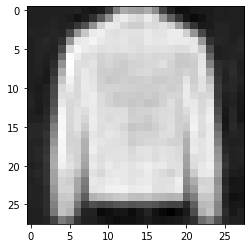

In [35]:
plt.imshow(xh[0,:,:], cmap="gray")
plt.show()

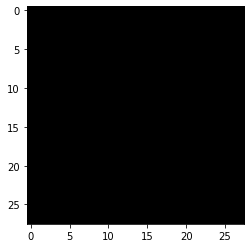

In [14]:
noise = np.ones((1,28,28))
plt.imshow(noise[0,:,:], cmap="gray")
plt.show()

In [15]:
xh_noise, _ = model(noise)

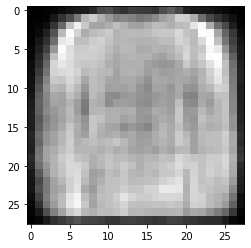

In [16]:
plt.imshow(xh_noise[0,:,:], cmap="gray")
plt.show()